In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv


# TCN LASSO REG - 150

In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense, Multiply,
    GlobalAveragePooling1D, Reshape
)
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
)
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Load dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity']).values
y = df['Activity'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract absolute coefficients from the best alpha model
feature_importance = np.abs(lasso.coef_)

# Get feature names
feature_names = df.drop(columns=["Activity"]).columns

# Select top 150 features based on importance
sorted_idx = np.argsort(feature_importance)[::-1][:150]  # Select top 150 features 
selected_features = np.array(feature_names)[sorted_idx]
num_features = len(selected_features)  # Get number of selected features

# Print the number of selected features
print(f"Number of features used for model training: {num_features}")

# Select corresponding columns from scaled dataset
X_selected = X_scaled[:, sorted_idx]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Reshape for TCN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define Attention Mechanism
def attention_block(inputs):
    """Attention Mechanism"""
    avg_pool = GlobalAveragePooling1D()(inputs)
    dense1 = Dense(units=inputs.shape[-1], activation="relu")(avg_pool)
    dense2 = Dense(units=inputs.shape[-1], activation="sigmoid")(dense1)
    attention = Multiply()([inputs, Reshape((1, inputs.shape[-1]))(dense2)])
    return attention

# Define TCN Residual Block with Dilated Convolutions
def residual_block(x, filters, dilation_rate):
    """TCN Residual Block"""
    conv1 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    dropout1 = Dropout(0.3)(relu1)

    conv2 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(dropout1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)

    # Residual Connection
    res = Add()([x, relu2])
    
    return res

# Cross-validation setup
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_training_time = None

# Cross-validation loop
with tqdm(total=kf.get_n_splits(), desc="Running Cross-Validation", unit="split") as pbar:
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define TCN Model
        input_layer = Input(shape=(X_train.shape[1], 1))
        
        # TCN Residual Blocks with Dilated Convolutions
        res_block1 = residual_block(input_layer, filters=64, dilation_rate=1)
        res_block2 = residual_block(res_block1, filters=64, dilation_rate=2)
        res_block3 = residual_block(res_block2, filters=64, dilation_rate=4)

        # Attention Mechanism
        attention_output = attention_block(res_block3)

        flatten = Flatten()(attention_output)
        dense1 = Dense(128, activation='relu')(flatten)
        dropout2 = Dropout(0.3)(dense1)
        output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model and track training time
        start_train_time = time.time()
        history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        training_time = time.time() - start_train_time

        # Evaluate the model
        val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_training_time = training_time

        pbar.update(1)  # Update progress bar

# Evaluate the best model
start_time = time.time()
y_pred_prob = best_model.predict(X_test)
inference_time = time.time() - start_time
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')

# Specificity Calculation
specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))


# Print Metrics
print(f"Features used for model training: {num_features}")
print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Training Time (Best Model): {best_training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")
print("\nBest Model Architecture Summary:")
best_model.summary()


Number of features used for model training: 150


Running Cross-Validation: 100%|██████████| 2/2 [01:04<00:00, 32.01s/split]


65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Features used for model training: 150
Model Test Accuracy: 0.9806
Precision: 0.9810
Recall (Sensitivity): 0.9806
Specificity: 0.9818
F1-Score: 0.9806
ROC AUC: 0.9993
Training Time (Best Model): 31.28 seconds
Inference Time: 1.62 seconds

Best Model Architecture Summary:


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 150, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_42 (Conv1D)        │ (None, 150, 64)        │            256 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_42    │ (None, 150, 64)        │            256 │ conv1d_42[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_42 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_28 (Dropout)      │ (None, 150, 64)        │              0 │ re_lu_42[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_43 (Conv1D)        │ (None, 150, 64)        │         12,352 │ dropout_28[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_43    │ (None, 150, 64)        │            256 │ conv1d_43[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_43 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_21 (Add)              │ (None, 150, 64)        │              0 │ input_layer_7[0][0],   │
│                           │                        │                │ re_lu_43[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_44 (Conv1D)        │ (None, 150, 64)        │         12,352 │ add_21[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_44    │ (None, 150, 64)        │            256 │ conv1d_44[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_44 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_29 (Dropout)      │ (None, 150, 64)        │              0 │ re_lu_44[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_45 (Conv1D)        │ (None, 150, 64)        │         12,352 │ dropout_29[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_45    │ (None, 150, 64)        │            256 │ conv1d_45[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_45 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_4… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_22 (Add)         

 Total params: 3,903,188 (14.89 MB)

 Trainable params: 1,300,806 (4.96 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2,601,614 (9.92 MB)

In [5]:
# MAIN CODE

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score
)
import time
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Load dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity']).values
y = df['Activity'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract absolute coefficients from the best alpha model
feature_importance = np.abs(lasso.coef_)

# Get feature names
feature_names = df.drop(columns=["Activity"]).columns

# Select top 100 features based on importance
sorted_idx = np.argsort(feature_importance)[::-1][:150]  # Select top 150 features
selected_features = np.array(feature_names)[sorted_idx]

# Select only the top 150 features
X_selected = X_scaled[:, sorted_idx]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Reshape for TCN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define TCN Residual Block with Dilated Convolutions
def residual_block(x, filters, dilation_rate):
    """TCN Residual Block"""
    conv1 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    dropout1 = Dropout(0.3)(relu1)

    conv2 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(dropout1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)

    # Residual Connection
    res = Add()([x, relu2])
    
    return res

# Cross-validation setup
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_training_time = None

# Cross-validation loop
with tqdm(total=kf.get_n_splits(), desc="Running Cross-Validation", unit="split") as pbar:
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define TCN Model
        input_layer = Input(shape=(X_train.shape[1], 1))
        
        # TCN Residual Blocks with Dilated Convolutions
        res_block1 = residual_block(input_layer, filters=64, dilation_rate=1)
        res_block2 = residual_block(res_block1, filters=64, dilation_rate=2)
        res_block3 = residual_block(res_block2, filters=64, dilation_rate=4)

        flatten = Flatten()(res_block3)
        dense1 = Dense(128, activation='relu')(flatten)
        dropout2 = Dropout(0.3)(dense1)
        output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model and track training time
        start_train_time = time.time()
        history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        training_time = time.time() - start_train_time

        # Evaluate the model
        val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_training_time = training_time

        pbar.update(1)  # Update progress bar

# Evaluate the best model
start_time = time.time()
y_pred_prob = best_model.predict(X_test)
inference_time = time.time() - start_time
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')

# Specificity Calculation
specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))

# Print renumbered model summary
print("----------------------------------------------")
# Print Metrics
print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Training Time (Best Model): {best_training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")

print("\nBest Model Architecture Summary:")
best_model.summary()

# MAIN CODE

Running Cross-Validation: 100%|██████████| 2/2 [00:57<00:00, 28.95s/split]


65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
----------------------------------------------
Model Test Accuracy: 0.9806
Precision: 0.9806
Recall (Sensitivity): 0.9806
Specificity: 0.9810
F1-Score: 0.9806
ROC AUC: 0.9993
Training Time (Best Model): 28.82 seconds
Inference Time: 1.11 seconds

Best Model Architecture Summary:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 150, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_30 (Conv1D)        │ (None, 150, 64)        │            256 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_30    │ (None, 150, 64)        │            256 │ conv1d_30[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_30 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_20 (Dropout)      │ (None, 150, 64)        │              0 │ re_lu_30[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_31 (Conv1D)        │ (None, 150, 64)        │         12,352 │ dropout_20[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_31    │ (None, 150, 64)        │            256 │ conv1d_31[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_31 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 150, 64)        │              0 │ input_layer_5[0][0],   │
│                           │                        │                │ re_lu_31[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_32 (Conv1D)        │ (None, 150, 64)        │         12,352 │ add_15[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 150, 64)        │            256 │ conv1d_32[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_32 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_21 (Dropout)      │ (None, 150, 64)        │              0 │ re_lu_32[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_33 (Conv1D)        │ (None, 150, 64)        │         12,352 │ dropout_21[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 150, 64)        │            256 │ conv1d_33[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_33 (ReLU)           │ (None, 150, 64)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)         

 Total params: 3,878,228 (14.79 MB)

 Trainable params: 1,292,486 (4.93 MB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 2,584,974 (9.86 MB)

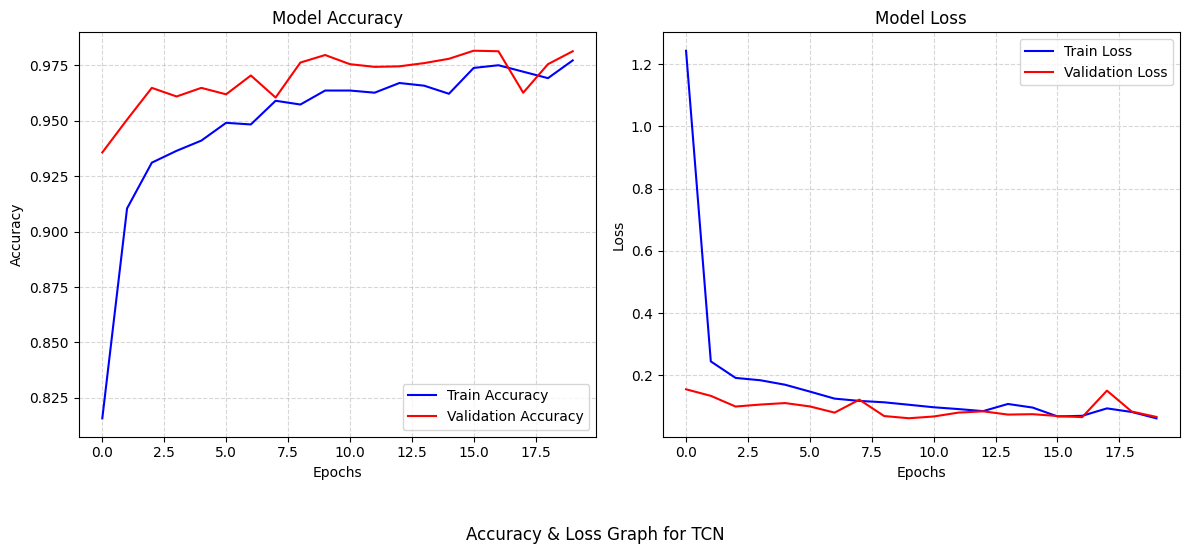

In [6]:
# Set white background
plt.style.use('default')

# Plot Accuracy & Loss Graph
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()

# Add text below the graph
plt.figtext(0.5, -0.09, "Accuracy & Loss Graph for TCN", ha="center", fontsize=12)

plt.show()


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score
)
import time
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm  # Progress bar

# Load dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity']).values
y = df['Activity'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)

# Extract absolute coefficients from the best alpha model
feature_importance = np.abs(lasso.coef_)

# Get feature names
feature_names = df.drop(columns=["Activity"]).columns

# Select top 150 features based on importance
sorted_idx = np.argsort(feature_importance)[::-1][:150]
selected_features = np.array(feature_names)[sorted_idx]

# Select only the top 150 features
X_selected = X_scaled[:, sorted_idx]

# 🔥 Plot the top 20 features
top_20_idx = sorted_idx[:20]
top_20_features = np.array(feature_names)[top_20_idx]
top_20_importance = feature_importance[top_20_idx]

plt.figure(figsize=(12, 6))
sns.barplot(x=top_20_importance, y=top_20_features, palette="viridis")
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 20 Important Features from LASSO Regression")
plt.show()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Reshape for TCN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define TCN Residual Block with Dilated Convolutions
def residual_block(x, filters, dilation_rate):
    """TCN Residual Block"""
    conv1 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    dropout1 = Dropout(0.3)(relu1)

    conv2 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(dropout1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)

    # Residual Connection
    res = Add()([x, relu2])
    
    return res

# Cross-validation setup
kf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
best_accuracy = 0
best_model = None
best_training_time = None

# Cross-validation loop
with tqdm(total=kf.get_n_splits(), desc="Running Cross-Validation", unit="split") as pbar:
    for train_index, val_index in kf.split(X_train, y_train):
        X_tr, X_val = X_train[train_index], X_train[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]

        # Define TCN Model
        input_layer = Input(shape=(X_train.shape[1], 1))
        
        # TCN Residual Blocks with Dilated Convolutions
        res_block1 = residual_block(input_layer, filters=64, dilation_rate=1)
        res_block2 = residual_block(res_block1, filters=64, dilation_rate=2)
        res_block3 = residual_block(res_block2, filters=64, dilation_rate=4)

        flatten = Flatten()(res_block3)
        dense1 = Dense(128, activation='relu')(flatten)
        dropout2 = Dropout(0.3)(dense1)
        output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        # Train the model and track training time
        start_train_time = time.time()
        history = model.fit(X_tr, y_tr, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=0)
        training_time = time.time() - start_train_time

        # Evaluate the model
        val_accuracy = model.evaluate(X_val, y_val, verbose=0)[1]
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model
            best_training_time = training_time

        pbar.update(1)  # Update progress bar

# Evaluate the best model
start_time = time.time()
y_pred_prob = best_model.predict(X_test)
inference_time = time.time() - start_time
y_pred = np.argmax(y_pred_prob, axis=1)

# Metrics Calculation
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(tf.keras.utils.to_categorical(y_test), y_pred_prob, multi_class='ovr')

# Specificity Calculation
specificity = np.mean(np.diag(cm) / np.sum(cm, axis=1))

print("\nBest Model Architecture Summary:")
best_model.summary()

# Function to print clean model summary with renumbered layers
def print_renumbered_model_summary(model):
    print("\nBest Model Architecture Summary:")
    print(f"{'Layer Type':<25}{'Output Shape':<30}{'Param #':<15}")
    print("=" * 75)

    layer_counts = {}  # Dictionary to track the count of each layer type

    for layer in model.layers:
        layer_type = layer.__class__.__name__  # Get layer type
        output_shape = str(layer.output_shape) if hasattr(layer, 'output_shape') else "N/A"
        param_count = layer.count_params() if hasattr(layer, 'count_params') else 0

        # Track counts and rename layer type
        if layer_type not in layer_counts:
            layer_counts[layer_type] = 1
        else:
            layer_counts[layer_type] += 1

        renamed_layer = f"{layer_type.lower()}_{layer_counts[layer_type]}"  # Format: conv1d_1, conv1d_2, etc.

        print(f"{renamed_layer:<25}{output_shape:<30}{param_count:<15}")

# Print renumbered model summary
print_renumbered_model_summary(best_model)
print("----------------------------------------------")
# Print Metrics
print(f"Model Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Training Time (Best Model): {best_training_time:.2f} seconds")
print(f"Inference Time: {inference_time:.2f} seconds")


In [ ]:
# VIZ code
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Dropout, ReLU, Flatten, Add, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,
    roc_auc_score, precision_recall_curve, roc_curve
)
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from graphviz import Digraph

# Load dataset
df = pd.read_csv('/kaggle/input/har-dataset/Human_Activity_Recognition_Using_Smartphones_Data.csv')

# Encode target labels
label_encoder = LabelEncoder()
df['Activity'] = label_encoder.fit_transform(df['Activity'])

# Separate features and target
X = df.drop(columns=['Activity']).values
y = df['Activity'].values

# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Feature Selection using LASSO
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_scaled, y)
feature_importance = np.abs(lasso.coef_)
feature_names = df.drop(columns=["Activity"]).columns
sorted_idx = np.argsort(feature_importance)[::-1][:150]  # Select top 150 features
selected_features = np.array(feature_names)[sorted_idx]
X_selected = X_scaled[:, sorted_idx]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Reshape for TCN input
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Define TCN Residual Block
def residual_block(x, filters, dilation_rate):
    conv1 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(x)
    bn1 = BatchNormalization()(conv1)
    relu1 = ReLU()(bn1)
    dropout1 = Dropout(0.3)(relu1)
    
    conv2 = Conv1D(filters=filters, kernel_size=3, padding='causal', dilation_rate=dilation_rate)(dropout1)
    bn2 = BatchNormalization()(conv2)
    relu2 = ReLU()(bn2)
    
    res = Add()([x, relu2])
    
    return res

# Build the TCN Model
input_layer = Input(shape=(X_train.shape[1], 1))
res_block1 = residual_block(input_layer, filters=64, dilation_rate=1)
res_block2 = residual_block(res_block1, filters=64, dilation_rate=2)
res_block3 = residual_block(res_block2, filters=64, dilation_rate=4)
flatten = Flatten()(res_block3)
dense1 = Dense(128, activation='relu')(flatten)
dropout2 = Dropout(0.3)(dense1)
output_layer = Dense(len(np.unique(y)), activation='softmax')(dropout2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=0)
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Visualization Functions
def plot_learning_curves(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.legend()
    plt.title("Loss Curve")
    plt.show()

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

def plot_roc_auc(y_true, y_pred_prob):
    plt.figure(figsize=(8, 6))
    for i in range(len(np.unique(y_true))):
        fpr, tpr, _ = roc_curve(y_true == i, y_pred_prob[:, i])
        plt.plot(fpr, tpr, label=f'Class {i}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.legend()
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-AUC Curve")
    plt.show()

def plot_tsne(X, y):
    tsne = TSNE(n_components=2, random_state=42)
    X_embedded = tsne.fit_transform(X)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar()
    plt.title("t-SNE Visualization of Feature Space")
    plt.show()

def plot_precision_recall(y_true, y_pred_prob):
    plt.figure(figsize=(8, 6))
    for i in range(y_pred_prob.shape[1]):
        precision, recall, _ = precision_recall_curve(y_true == i, y_pred_prob[:, i])
        plt.plot(recall, precision, marker='.', label=f'Class {i}')
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve (One vs Rest)")
    plt.legend()
    plt.show()

def plot_correlation_matrix(X):
    corr = pd.DataFrame(X, columns=selected_features).corr()
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.title("Feature Correlation Matrix")
    plt.show()

def plot_feature_importance():
    plt.figure(figsize=(10, 5))
    plt.barh(selected_features[:20], feature_importance[sorted_idx][:20])
    plt.gca().invert_yaxis()
    plt.xlabel("Feature Importance")
    plt.title("Top 20 Important Features")
    plt.show()

def plot_histograms(X):
    plt.figure(figsize=(12, 6))
    for i in range(3):  
        plt.subplot(1, 3, i+1)
        plt.hist(X[:, i], bins=30, alpha=0.7)
        plt.title(f"Feature {i+1} Distribution")
    plt.show()

def visualize_tcn_model():
    dot = Digraph(format='png')
    dot.node('Input', 'Input Layer', shape='box', style='filled', fillcolor='lightblue')
    dot.node('RB1', 'Residual Block 1 (64 filters, d=1)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('RB2', 'Residual Block 2 (64 filters, d=2)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('RB3', 'Residual Block 3 (64 filters, d=4)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('Flatten', 'Flatten', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dense1', 'Dense 128 (ReLU)', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('Dropout', 'Dropout (0.3)', shape='box', style='filled', fillcolor='lightyellow')
    dot.node('Output', 'Dense Softmax (Classes)', shape='ellipse', style='filled', fillcolor='lightblue')
    dot.edge('Input', 'RB1')
    dot.edge('RB1', 'RB2')
    dot.edge('RB2', 'RB3')
    dot.edge('RB3', 'Flatten')
    dot.edge('Flatten', 'Dense1')
    dot.edge('Dense1', 'Dropout')
    dot.edge('Dropout', 'Output')
    return dot

# Run the visualizations
plot_learning_curves(history)
plot_confusion_matrix(y_test, y_pred)
plot_roc_auc(y_test, y_pred_prob)
plot_tsne(X_test.reshape(X_test.shape[0], -1), y_test)
plot_precision_recall(y_test, y_pred_prob)
plot_correlation_matrix(X_selected)
plot_feature_importance()
plot_histograms(X_selected)
visualize_tcn_model().render('tcn_model', view=True)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_distribution(X, feature_names):
    """Plot histograms for the top selected features."""
    num_features = min(10, X.shape[1])  # Show top 10 features
    plt.figure(figsize=(12, 8))
    
    for i in range(num_features):
        plt.subplot(2, 5, i + 1)
        sns.histplot(X[:, i], kde=True, bins=30)
        plt.title(f"Feature: {feature_names[i]}")
    
    plt.tight_layout()
    plt.show()

# Run the feature distribution visualization
plot_feature_distribution(X_selected, selected_features)


In [ ]:
def plot_class_distribution(y, label_encoder):
    """Plot the class distribution in the dataset."""
    class_labels = label_encoder.classes_
    plt.figure(figsize=(8, 6))
    sns.countplot(x=y, palette="viridis")
    plt.xticks(ticks=range(len(class_labels)), labels=class_labels, rotation=45)
    plt.title("Class Distribution in Dataset")
    plt.xlabel("Activity Classes")
    plt.ylabel("Count")
    plt.show()

# Run the class distribution visualization
plot_class_distribution(y, label_encoder)


In [ ]:
from graphviz import Digraph
from IPython.display import Image

def plot_tcn_architecture():
    dot = Digraph(comment='TCN Model Architecture')
    dot.attr(rankdir='LR') 
    # Nodes (Layers)
    dot.node('Input', 'Input Layer\n(150, 1)', shape='box', style='filled', fillcolor='lightblue')
    dot.node('Res1', 'Residual Block 1\n(64 filters, dilation=1)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('Res2', 'Residual Block 2\n(64 filters, dilation=2)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('Res3', 'Residual Block 3\n(64 filters, dilation=4)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('Flatten', 'Flatten Layer', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dense', 'Dense (128 neurons)\nReLU Activation', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('Dropout', 'Dropout (0.3)', shape='box', style='filled', fillcolor='lightyellow')
    dot.node('Output', 'Output Layer\nDense + Softmax', shape='box', style='filled', fillcolor='lightblue')

    # Edges (Connections)
    dot.edge('Input', 'Res1')
    dot.edge('Res1', 'Res2')
    dot.edge('Res2', 'Res3')
    dot.edge('Res3', 'Flatten')
    dot.edge('Flatten', 'Dense')
    dot.edge('Dense', 'Dropout')
    dot.edge('Dropout', 'Output')

    return dot

# Generate and visualize the model architecture
arch_diagram = plot_tcn_architecture()
arch_diagram.render('TCN_Model_Architecture', format='png', cleanup=False)  # Save as PNG
arch_diagram  # Display

# Generate and visualize the model architecture
arch_diagram = plot_tcn_architecture()
arch_diagram.render('TCN_Model_Architecture', format='png', cleanup=False)  # Save as PNG

# ✅ Display the saved image
Image(filename='TCN_Model_Architecture.png')



In [ ]:
from graphviz import Digraph

def plot_tcn_architecture():
    dot = Digraph(comment='TCN Model Architecture')

    # Nodes (Layers)
    dot.node('Input', 'Input Layer\n(150, 1)', shape='box', style='filled', fillcolor='lightblue')
    dot.node('Res1', 'Residual Block 1\n(64 filters, dilation=1)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('Res2', 'Residual Block 2\n(64 filters, dilation=2)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('Res3', 'Residual Block 3\n(64 filters, dilation=4)', shape='box', style='filled', fillcolor='lightgray')
    dot.node('Flatten', 'Flatten Layer', shape='box', style='filled', fillcolor='lightgreen')
    dot.node('Dense', 'Dense (128 neurons)\nReLU Activation', shape='box', style='filled', fillcolor='lightcoral')
    dot.node('Dropout', 'Dropout (0.3)', shape='box', style='filled', fillcolor='lightyellow')
    dot.node('Output', 'Output Layer\nDense + Softmax', shape='box', style='filled', fillcolor='lightblue')

    # Edges (Connections)
    dot.edge('Input', 'Res1')
    dot.edge('Res1', 'Res2')
    dot.edge('Res2', 'Res3')
    dot.edge('Res3', 'Flatten')
    dot.edge('Flatten', 'Dense')
    dot.edge('Dense', 'Dropout')
    dot.edge('Dropout', 'Output')

    return dot

# Generate and visualize the model architecture
arch_diagram = plot_tcn_architecture()
arch_diagram.render('TCN_Model_Architecture', format='png', cleanup=False)  # Save as PNG
arch_diagram  # Display


In [ ]:
from graphviz import Digraph
from IPython.display import display, Image

def visualize_tcn_model(model, filename="TCN_Model_Graph"):
    """
    Generates a Graphviz diagram of the TCN model with box shapes.
    """
    dot = Digraph(format="png")
    dot.attr(rankdir="TB")  # Top-to-bottom layout
    dot.attr(rankdir='LR') 

    # Add input layer
    input_shape = model.input_shape[1:] if hasattr(model, "input_shape") else "Unknown"
    dot.node("Input", f"Input Layer\nShape: {input_shape}", shape="box", style="filled", fillcolor="lightblue")

    layer_counts = {}  # Dictionary to track the count of each layer type
    prev_layer = "Input"  # Track previous layer for connections

    for layer in model.layers:
        layer_type = layer.__class__.__name__  # Extract layer name
        output_shape = str(layer.output_shape) if hasattr(layer, 'output_shape') else "Unknown"

        # Track counts and rename layer
        if layer_type not in layer_counts:
            layer_counts[layer_type] = 1
        else:
            layer_counts[layer_type] += 1

        layer_name = f"{layer_type}_{layer_counts[layer_type]}"
        layer_label = f"{layer_type}\n{output_shape}"

        dot.node(layer_name, layer_label, shape="box", style="filled", fillcolor="lightgray")

        # Connect previous layer to current layer
        dot.edge(prev_layer, layer_name)
        prev_layer = layer_name  # Update previous layer

    # Render the diagram
    dot.render(filename, format="png", cleanup=False)

    # Display the image in Jupyter Notebook
    display(Image(filename=f"{filename}.png"))

# Generate and visualize the model architecture
visualize_tcn_model(best_model)


In [ ]:
# Plot top selected features
plt.figure(figsize=(12, 6))
plt.bar(range(len(selected_features)), feature_importance[sorted_idx], align="center", color="blue")
plt.xticks(range(len(selected_features)), selected_features, rotation=90)
plt.xlabel("Feature Name")
plt.ylabel("Importance (LASSO Coefficients)")
plt.title("Top 150 Feature Importance using LASSO")
plt.show()

In [2]:
# detailed model summary
# Function to print clean model summary with renumbered layers
def print_renumbered_model_summary(model):
    print("\nBest Model Architecture Summary:")
    print(f"{'Layer Type':<25}{'Output Shape':<30}{'Param #':<15}")
    print("=" * 75)

    layer_counts = {}  # Dictionary to track the count of each layer type

    for layer in model.layers:
        layer_type = layer.__class__.__name__  # Get layer type
        output_shape = str(layer.output_shape) if hasattr(layer, 'output_shape') else "N/A"
        param_count = layer.count_params() if hasattr(layer, 'count_params') else 0

        # Track counts and rename layer type
        if layer_type not in layer_counts:
            layer_counts[layer_type] = 1
        else:
            layer_counts[layer_type] += 1

        renamed_layer = f"{layer_type.lower()}_{layer_counts[layer_type]}"  # Format: conv1d_1, conv1d_2, etc.

        print(f"{renamed_layer:<25}{output_shape:<30}{param_count:<15}")